# SOC Analysis

Comparing Coulomb counting and voltage interpolation methods.

In [17]:
from data_analysis.data_tools.time_series import TimeSeries
from data_analysis.data_tools.influx_client import InfluxClient
from data_analysis.soc import get_soc_from_voltage, get_soc_from_coulomb_counting

import matplotlib.pyplot as plt
import numpy as np

# 1st Run
start = "2024-07-07T02:00:00Z"
stop = "2024-07-07T05:17:15Z"
# start = "2024-06-30T15:16:18Z"
# stop = "2024-06-30T21:46:20Z"
# start = "2024-06-30T15:45:23Z"
# stop = "2024-06-30T16:28:14Z"

client = InfluxClient()

In [18]:
pack_voltage: TimeSeries = client.query_time_series(start, stop, "TotalPackVoltage", units="V")
pack_current: TimeSeries = client.query_time_series(start, stop, "PackCurrent", units="A")
pack_current, pack_voltage = TimeSeries.align(pack_current, pack_voltage)

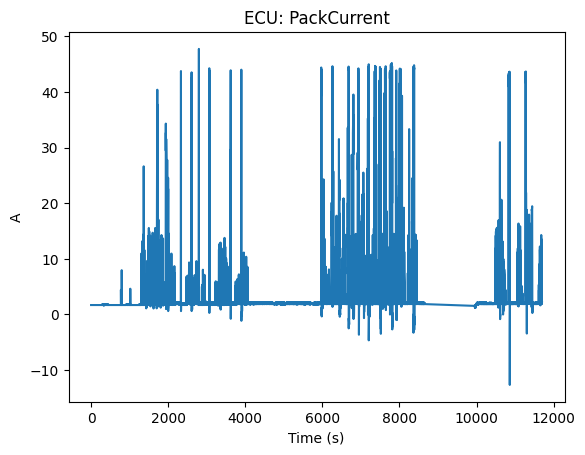

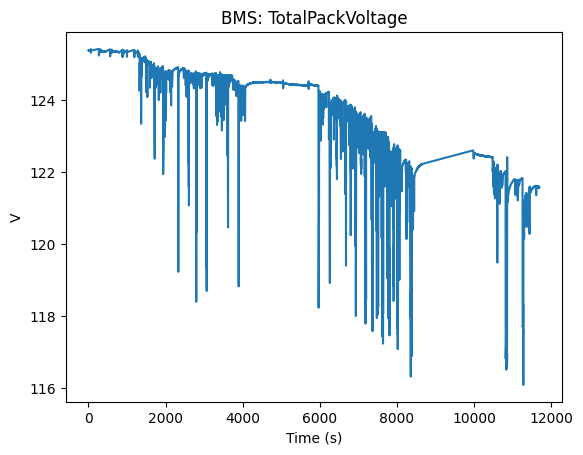

In [19]:
pack_current.plot()
pack_voltage.plot()

## Voltage Interpolation

Let's try to estimate SOC with voltage interpolation first.

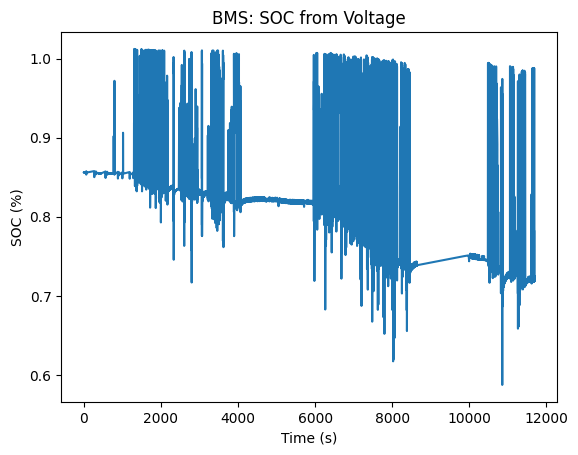

In [20]:
soc_voltage = pack_voltage.promote(get_soc_from_voltage(pack_voltage, pack_current))
soc_voltage.meta["field"] = "SOC from Voltage"
soc_voltage.units = "SOC (%)"
soc_voltage.plot()

In [21]:
print(f"Initial SOC: {soc_voltage[0]}")
print(f"Final SOC: {soc_voltage[-1]}")
print(f"Change in SOC: {soc_voltage[0] - soc_voltage[-1]}")

Initial SOC: 0.8563126067284923
Final SOC: 0.7246029925818263
Change in SOC: 0.13170961414666604


## Coulomb Counting

Now, let's look at Coulomb counting, using the initial SOC found with the previous method as our initial SOC.

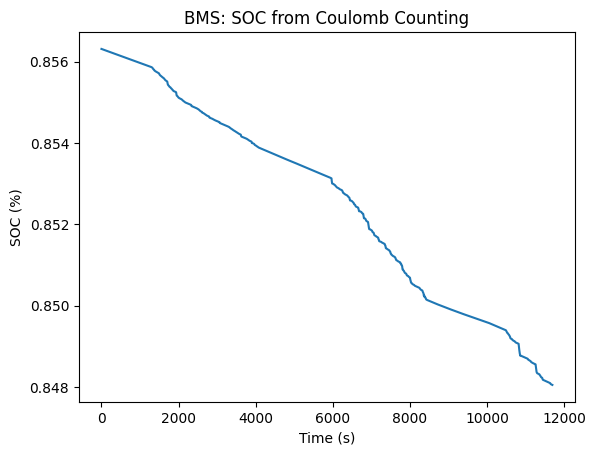

In [22]:
soc_coulomb_counting, _, _ = pack_voltage.promote(get_soc_from_coulomb_counting(soc_voltage[0], pack_voltage, -pack_current, pack_voltage.granularity))
soc_coulomb_counting.meta["field"] = "SOC from Coulomb Counting"
soc_coulomb_counting.units = "SOC (%)"
soc_coulomb_counting.plot()

In [23]:
print(f"Initial SOC: {soc_coulomb_counting[0]}")
print(f"Final SOC: {soc_coulomb_counting[-1]}")
print(f"Change in SOC: {soc_coulomb_counting[0] - soc_coulomb_counting[-1]}")

Initial SOC: 0.8563126067284923
Final SOC: 0.8480530890762039
Change in SOC: 0.008259517652288384


## Results

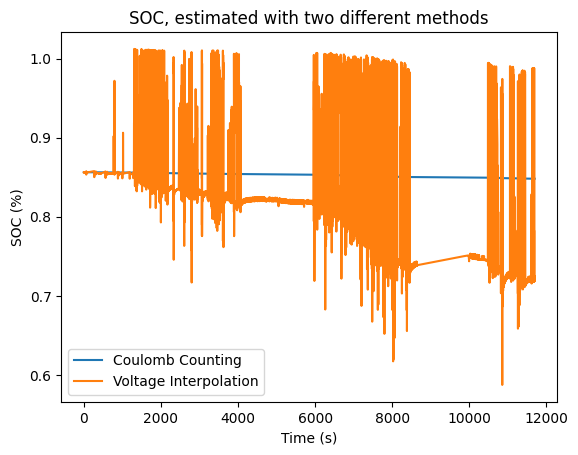

In [24]:
fig, ax = plt.subplots()

ax.plot(soc_coulomb_counting.x_axis, soc_coulomb_counting, label="Coulomb Counting")
ax.plot(soc_voltage.x_axis, soc_voltage, label="Voltage Interpolation")

ax.set_xlabel("Time (s)")
ax.set_ylabel("SOC (%)")
ax.set_title("SOC, estimated with two different methods")

plt.legend()
plt.show()